This file is about importing test data from [CVRPLIB](http://vrp.atd-lab.inf.puc-rio.br/index.php/en/) and clustering this data into 100 node instances.

In [ ]:
# Conecting my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Changing the current directory to 'Diss_Code'
%cd /content/drive/MyDrive/Diss_Code/My_Code

/content/drive/MyDrive/Diss_Code/My_Code


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import pickle
import copy
import csv
import pandas as pd
import ast
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew

In [ ]:
!pip install vrplib

In [ ]:
import vrplib

In [ ]:
# # Download instances
# for instance in vrplib.list_names(low=3000, high=30000):
#   vrplib.download_instance(instance, f"{instance}_instances")
#   vrplib.download_solution(instance, f"{instance}_solutions")

In [ ]:
# Read VRPLIB formatted instances (default)
# We are concerned with the large instances of VRP
vrplib.list_names(low=3000, high=30000)

['Antwerp1',
 'Antwerp2',
 'Brussels1',
 'Brussels2',
 'Flanders1',
 'Flanders2',
 'Ghent1',
 'Ghent2',
 'Leuven1',
 'Leuven2']

Need to also make the original dataset in the format of the testing data so
that I have a benchmark

### Classes and Functions

In [ ]:
class VRPlib:
    def __init__(self, dataset_instance, dataset_solution):
        self.instance = vrplib.read_instance(dataset_instance)
        self.solution = vrplib.read_solution(dataset_solution)
        self.customer_coords = self.instance['node_coord'][1:]
        self.depot_coords = self.instance['node_coord'][0, :]
        self.node_demand = self.instance['demand']
        self.x_customer = self.customer_coords[:, 0]
        self.y_customer = self.customer_coords[:, 1]
        self.x_depot = self.depot_coords[0]
        self.y_depot = self.depot_coords[1]
        self.capacity = self.instance['capacity']
        self.cluster_labels = None
        self.cluster_centers = None
        self.instance_cluster_dict = {}

    def unique_demand_values(self):
      return set(self.node_demand)

    def full_plot(self):
        plt.figure(figsize=(10, 10))
        plt.scatter(self.x_customer, self.y_customer, c='steelblue')
        plt.scatter(self.x_depot, self.y_depot, c='lime', marker='*')
        plt.show()
        plt.close()

    def check(self):
      return self.instance

    def benchmark(self):
      unclustered_dataset = (self.depot_coords.tolist(),
                             self.customer_coords.tolist(),
                             self.node_demand.tolist()[1:],
                             self.capacity)
      return unclustered_dataset

    def K_means(self):
        num_clusters = int(len(self.customer_coords) / 100)
        # num_clusters = 1
        kmeans = KMeans(n_clusters=num_clusters, random_state=1234)
        kmeans.fit(self.customer_coords)
        self.cluster_labels = kmeans.labels_
        self.cluster_centers = kmeans.cluster_centers_

    def instance_cluster(self):

        unique_clusters = np.unique(self.cluster_labels)

        for i, selected_cluster in enumerate(unique_clusters):
            self.instance_cluster_dict[f'cluster_{i}'] = {}
            cluster_data = self.customer_coords[self.cluster_labels == selected_cluster]
            cluster_demand = self.node_demand[1:][self.cluster_labels == selected_cluster]
            self.instance_cluster_dict[f'cluster_{i}']['node_xy'] = cluster_data/np.max(self.customer_coords)
            self.instance_cluster_dict[f'cluster_{i}']['depot_xy'] = self.depot_coords/np.max(self.customer_coords)
            self.instance_cluster_dict[f'cluster_{i}']['centroid'] = self.cluster_centers[selected_cluster]/np.max(self.customer_coords)
            self.instance_cluster_dict[f'cluster_{i}']['node_demand'] = cluster_demand
            # demand = np.array([], dtype=int)
            # cum_demand = np.array([], dtype=int)

            # for coord in cluster_data:
            #     indices = np.where((self.instance['node_coord'] == coord).all(axis=1))[0]
            #     demand = np.append(demand, self.node_demand[indices])

            # self.instance_cluster_dict[f'cluster_{i}']['node_demand'] = demand
            self.instance_cluster_dict[f'cluster_{i}']['cum_demand'] = sum(cluster_demand)

        # for cluster in self.instance_cluster_dict:
        #     self.instance_cluster_dict[cluster]['node_coord_and_depot'] = np.append(
        #         self.instance_cluster_dict[cluster]['node_xy'], [self.instance_cluster_dict[cluster]['depot_xy']], axis=0)

        return self.instance_cluster_dict

    def instance_cluster_as_torch(self):

      torch_instance_cluster = {}
      problem_size = {}
      POMO_test_set = {}
      Kool_test_set_depot = {}
      Kool_test_set_centroid = {}

      for cluster in self.instance_cluster_dict:
        torch_instance_cluster[cluster] = {}
        for key in self.instance_cluster_dict[cluster]:
          torch_instance_cluster[cluster][key] = torch.from_numpy(np.array(self.instance_cluster_dict[cluster][key]))

      # POMO test set
      keys_to_add = ['depot_xy', 'node_xy', 'node_demand']
      for cluster in self.instance_cluster_dict:
        POMO_test_set[cluster] = {}
        for key in keys_to_add:
         POMO_test_set[cluster][key] = torch.from_numpy(np.array(self.instance_cluster_dict[cluster][key]))

      for cluster in self.instance_cluster_dict:
        POMO_test_set[cluster]['node_demand'] = (POMO_test_set[cluster]['node_demand']/self.capacity)

      for cluster in self.instance_cluster_dict:
         POMO_test_set[cluster]['depot_xy'] = (POMO_test_set[cluster]['depot_xy'])

      for cluster in POMO_test_set:
        # problem_size.append(len(POMO_test_set[cluster]['node_xy'][0]))
        problem_size[cluster] = len(POMO_test_set[cluster]['node_xy'])

      # Kool test set
      for cluster in self.instance_cluster_dict:
        Kool_test_set_depot[cluster] = (self.instance_cluster_dict[cluster]['depot_xy'].tolist(),
                                     self.instance_cluster_dict[cluster]['node_xy'].tolist(),
                                     self.instance_cluster_dict[cluster]['node_demand'].tolist(),
                                     self.capacity)


      # Kool test set with centroid as depot
      for cluster in self.instance_cluster_dict:
        Kool_test_set_centroid[cluster] = (self.instance_cluster_dict[cluster]['centroid'].tolist(),
                                     self.instance_cluster_dict[cluster]['node_xy'].tolist(),
                                     self.instance_cluster_dict[cluster]['node_demand'].tolist(),
                                     self.capacity)


      return torch_instance_cluster, POMO_test_set, Kool_test_set_depot, Kool_test_set_centroid, problem_size

    def plot_k_means(self):
        self.K_means()
        plt.scatter(self.x_customer/np.max(self.customer_coords), self.y_customer/np.max(self.customer_coords), c=self.cluster_labels, cmap='tab20')
        plt.scatter(self.cluster_centers[:, 0]/np.max(self.customer_coords), self.cluster_centers[:, 1]/np.max(self.customer_coords), c='red', marker='x')
        plt.scatter(self.x_depot/np.max(self.customer_coords), self.y_depot/np.max(self.customer_coords), marker='*',c='red')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title('K-means Clustering')
        plt.show()
        plt.close()

    def plot_individual_clusters(self):
        instance_cluster_dict = self.instance_cluster_dict
        unique_clusters = np.unique(self.cluster_labels)
        num_clusters = len(unique_clusters)

        fig, axs = plt.subplots(int(num_clusters / (len(self.customer_coords) / 1000)), int(num_clusters / 10), figsize=(15, 20))

        for i, cluster in enumerate(instance_cluster_dict):
            cluster_data = instance_cluster_dict[cluster]['node_xy']
            x_customer_cluster = cluster_data[:, 0]
            y_customer_cluster = cluster_data[:, 1]
            # print(x_customer_cluster)
            ax = axs[i // int(num_clusters / 10), i % int(num_clusters / 10)] if num_clusters > 1 else axs
            ax.scatter(x_customer_cluster, y_customer_cluster, c='lightsteelblue')
            ax.scatter(instance_cluster_dict[f'cluster_{i}']['centroid'][0], instance_cluster_dict[f'cluster_{i}']['centroid'][1], c='red', marker='x')
            ax.scatter(self.x_depot/np.max(self.customer_coords), self.y_depot/np.max(self.customer_coords), marker = '*', c='lime', s=200, edgecolor='black')
            ax.set_xlabel('X-axis')
            ax.set_ylabel('Y-axis')
            ax.set_title('Cluster ' + str(cluster))

        plt.tight_layout()
        plt.show()
        plt.close()

    def plot_x_dist(self):
        instance_cluster_dict = self.instance_cluster_dict
        unique_clusters = np.unique(self.cluster_labels)
        num_clusters = len(unique_clusters)

        fig, axs = plt.subplots(int(num_clusters / (len(self.customer_coords) / 1000)), int(num_clusters / 10), figsize=(15, 20))

        for i, cluster in enumerate(instance_cluster_dict):
            ax = axs[i // int(num_clusters / 10), i % int(num_clusters / 10)] if num_clusters > 1 else axs
            ax.hist(instance_cluster_dict[cluster]['node_coord_and_depot'][:, 0])
            ax.set_xlabel('X Values')
            ax.set_ylabel('Amount')
            ax.set_title('Cluster ' + str(cluster))

        plt.tight_layout()
        plt.show()

    def plot_y_dist(self):
        instance_cluster_dict = self.instance_cluster_dict
        unique_clusters = np.unique(self.cluster_labels)
        num_clusters = len(unique_clusters)

        fig, axs = plt.subplots(int(num_clusters / (len(self.customer_coords) / 1000)), int(num_clusters / 10), figsize=(15, 20))

        for i, cluster in enumerate(instance_cluster_dict):
            ax = axs[i // int(num_clusters / 10), i % int(num_clusters / 10)] if num_clusters > 1 else axs
            ax.hist(instance_cluster_dict[cluster]['node_coord_and_depot'][:, 1])
            ax.set_xlabel('Y Values')
            ax.set_ylabel('Amount')
            ax.set_title('Cluster ' + str(cluster))

        plt.tight_layout()
        plt.show()



In [ ]:
def min_max_depot_normalizer(test_set):

  normalized_test_set = {}

  for cluster in test_set:
    normalized_test_set[cluster] = {}
    values_to_normalize = copy.copy(test_set[cluster]['node_xy'].tolist())
    # First have to add the depot to the nodes
    values_to_normalize.append(test_set[cluster]['depot_xy'].tolist())

    # Normalize values using Min-Max scaling
    min_value = np.min(values_to_normalize)
    max_value = np.max(values_to_normalize)
    normalized_values = (values_to_normalize - min_value) / (max_value - min_value)

    nodes = normalized_values[:-1]
    depot = normalized_values[-1]

    normalized_test_set[cluster]['node_xy'] = nodes
    normalized_test_set[cluster]['depot_xy'] = depot
    normalized_test_set[cluster]['centroid'] = test_set[cluster]['centroid']
    normalized_test_set[cluster]['node_demand'] = test_set[cluster]['node_demand']
    normalized_test_set[cluster]['cum_demand'] = test_set[cluster]['cum_demand']

  return normalized_test_set

In [ ]:
def min_max_centorid_normalizer(test_set):

  normalized_test_set = {}

  for cluster in test_set:
    normalized_test_set[cluster] = {}
    values_to_normalize = copy.copy(test_set[cluster]['node_xy'].tolist())
    # First have to add the depot to the nodes
    values_to_normalize.append(test_set[cluster]['centroid'].tolist())

    # Normalize values using Min-Max scaling
    min_value = np.min(values_to_normalize)
    max_value = np.max(values_to_normalize)
    normalized_values = (values_to_normalize - min_value) / (max_value - min_value)

    nodes = normalized_values[:-1]
    depot = normalized_values[-1]

    normalized_test_set[cluster]['node_xy'] = nodes
    normalized_test_set[cluster]['depot_xy'] = depot
    normalized_test_set[cluster]['centroid'] = test_set[cluster]['centroid']
    normalized_test_set[cluster]['node_demand'] = test_set[cluster]['node_demand']
    normalized_test_set[cluster]['cum_demand'] = test_set[cluster]['cum_demand']

  return normalized_test_set

In [ ]:
Antwerp1 = VRPlib("Antwerp1_instances", "Antwerp1_solutions")
Antwerp2 = VRPlib("Antwerp2_instances", "Antwerp2_solutions")

In [ ]:
Brussels1 = VRPlib("Brussels1_instances", "Brussels1_solutions")
Brussels2 = VRPlib("Brussels2_instances", "Brussels2_solutions")

In [ ]:
Flanders1 = VRPlib("Flanders1_instances", "Flanders1_solutions")
Flanders2 = VRPlib("Flanders2_instances", "Flanders2_solutions")

In [ ]:
Ghent1 = VRPlib("Ghent1_instances", "Ghent1_solutions")
Ghent2 = VRPlib("Ghent2_instances", "Ghent2_solutions")

In [ ]:
Leuven1 = VRPlib("Leuven1_instances", "Leuven1_solutions")
Leuven2 = VRPlib("Leuven2_instances", "Leuven2_solutions")

In [ ]:
datasets = [Antwerp1,
 Antwerp2,
 Brussels1,
 Brussels2,
 Flanders1,
 Flanders2,
 Ghent1,
 Ghent2,
 Leuven1,
 Leuven2]

In [ ]:
# for dataset in datasets:
#   print(np.max(dataset.customer_coords))


In [ ]:
# datasets = [Leuven1, Leuven2]

In [ ]:
# for dataset in datasets:
  # print(dataset.unique_demand_values())

In [ ]:
# Antwerp1.instance['name']

## Full Plot

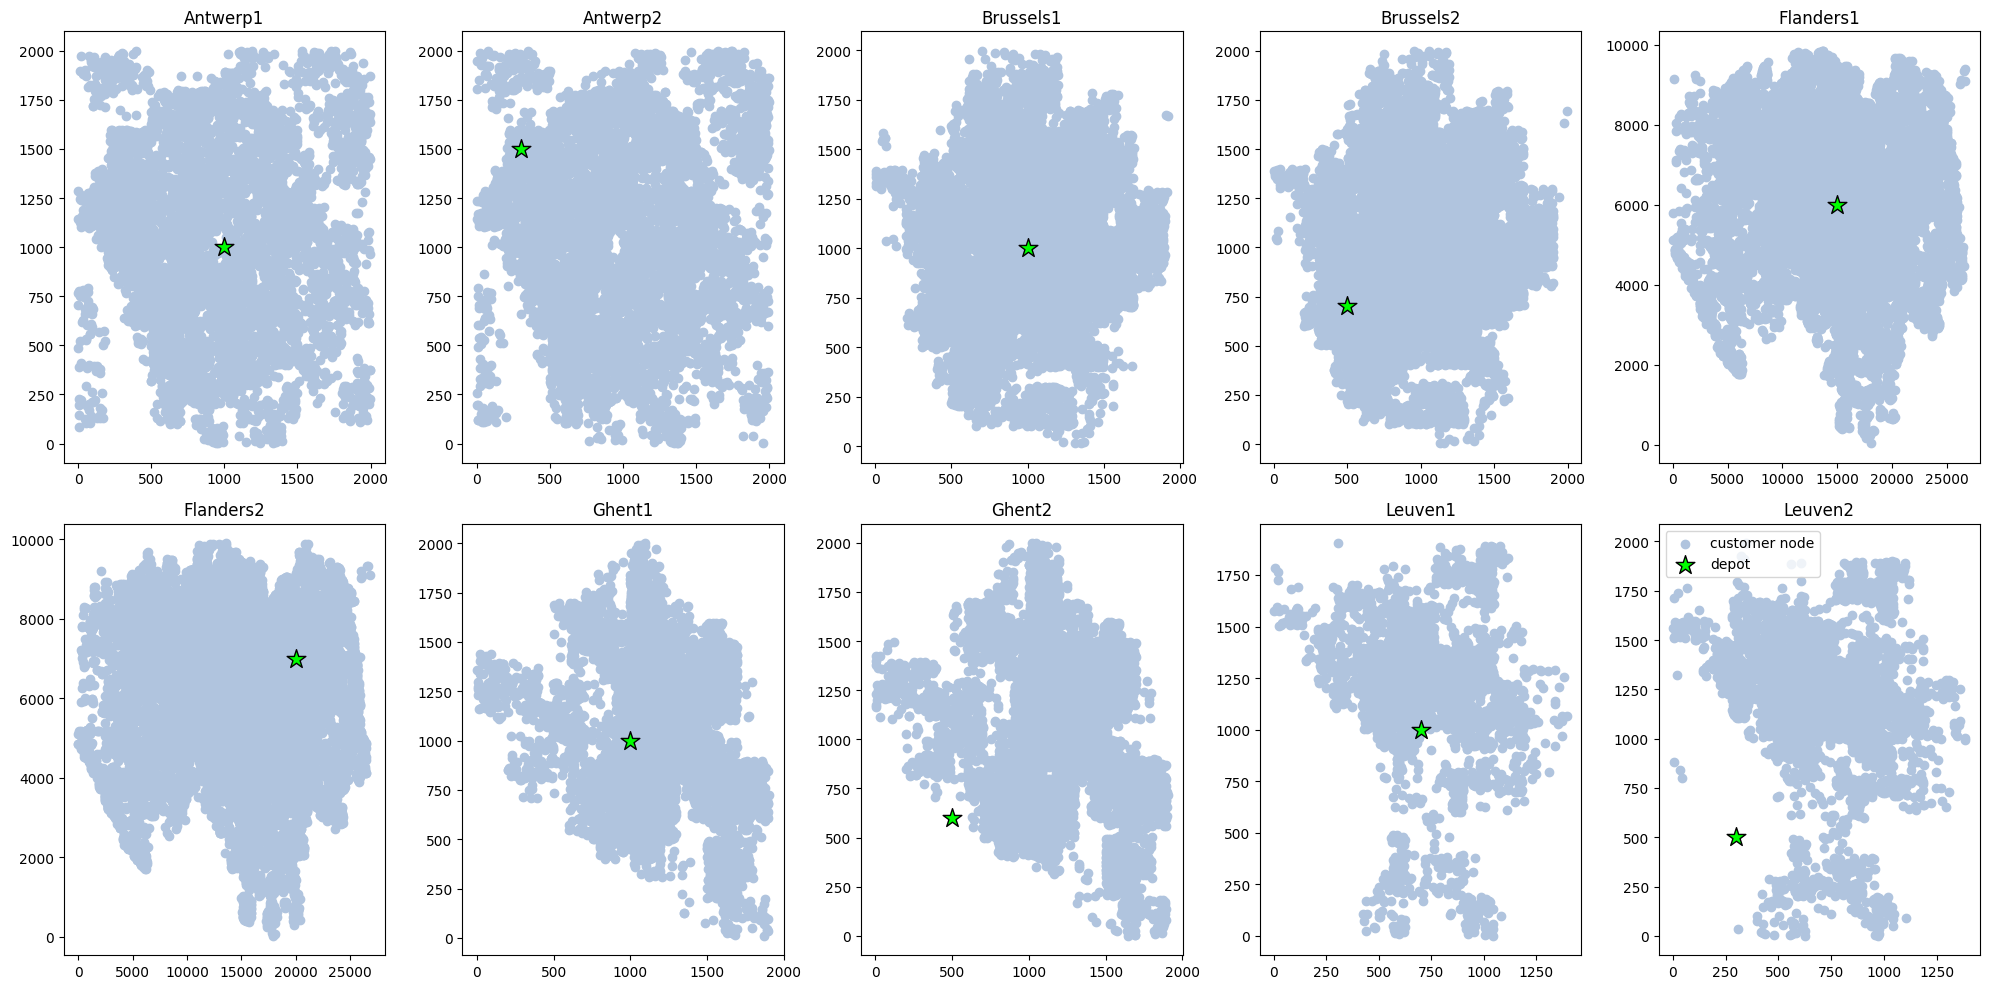

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Loop over datasets and axes at the same time
for dataset, ax in zip(datasets, axes):

    # Create the subplot
    ax.scatter(dataset.x_customer, dataset.y_customer, c='lightsteelblue', label='customer node')
    ax.scatter(dataset.x_depot, dataset.y_depot, marker='*', c='lime', edgecolor='black', s=200, label='depot')

    # Optionally, add a title to each subplot (assuming your dataset has a name attribute)
    ax.set_title(dataset.instance['name'])

# Show the full plot with all subplots
plt.tight_layout()
plt.legend()
# Save the plot as a PNG file
plt.savefig('/content/drive/MyDrive/Diss_Code/Figures/full_plots.png')
plt.show()
# Optionally, you can also close the plot after saving to release memory
plt.close()

In [ ]:
# VRP.full_plot()
# VRP.benchmark()
# VRP.K_means()
# VRP.instance_cluster()
# VRP.instance_cluster_as_torch()
# VRP.plot_k_means()
# VRP.plot_individual_clusters()
# VRP.plot_x_dist()

# Clustering

## Running the clustering class attribute

In [ ]:
for dataset in datasets:
  dataset.K_means()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [ ]:
for dataset in datasets:
  dataset.instance_cluster()

In [ ]:
for dataset in datasets:
  dataset.instance_cluster_as_torch()

In [ ]:
# for dataset in datasets:
#   dataset.plot_k_means()

## Exporting the Cluster Dict as Files that will be used in results

In [ ]:
def customers_and_depot(instance_cluster_dict):
  dictionary_depot = {}
  dictionary_centroid = {}
  for clusters in instance_cluster_dict:
    dictionary_depot[clusters] = [instance_cluster_dict[clusters]['depot_xy'].tolist(), instance_cluster_dict[clusters]['node_xy'].tolist()]
    dictionary_centroid[clusters] = [instance_cluster_dict[clusters]['centroid'].tolist(), instance_cluster_dict[clusters]['node_xy'].tolist()]

  return dictionary_depot, dictionary_centroid

In [ ]:
Leuven1_depot, Leuven1_centroid = customers_and_depot(Leuven1.instance_cluster_dict)
Leuven2_depot, Leuven2_centroid = customers_and_depot(Leuven2.instance_cluster_dict)

Ghent1_depot, Ghent1_centroid = customers_and_depot(Ghent1.instance_cluster_dict)
Ghent2_depot, Ghent2_centroid = customers_and_depot(Ghent2.instance_cluster_dict)

Brussels1_depot, Brussels1_centroid = customers_and_depot(Brussels1.instance_cluster_dict)
Brussels2_depot, Brussels2_centroid = customers_and_depot(Brussels2.instance_cluster_dict)

Flanders1_depot, Flanders1_centroid = customers_and_depot(Flanders1.instance_cluster_dict)
Flanders2_depot, Flanders2_centroid = customers_and_depot(Flanders2.instance_cluster_dict)

Antwerp1_depot, Antwerp1_centroid = customers_and_depot(Antwerp1.instance_cluster_dict)
Antwerp2_depot, Antwerp2_centroid = customers_and_depot(Antwerp2.instance_cluster_dict)

In [ ]:
dicts = [Leuven1_depot, Leuven1_centroid, Leuven2_depot, Leuven2_centroid,
         Ghent1_depot, Ghent1_centroid, Ghent2_depot, Ghent2_centroid,
         Brussels1_depot, Brussels1_centroid, Brussels2_depot, Brussels2_centroid,
         Flanders1_depot, Flanders1_centroid, Flanders2_depot, Flanders2_centroid,
         Antwerp1_depot, Antwerp1_centroid, Antwerp2_depot, Antwerp2_centroid]

# dicts = [Leuven1_depot, Leuven2_depot,
#          Ghent1_depot, Ghent2_depot,
#          Brussels1_depot, Brussels2_depot,
#          Flanders1_depot, Flanders2_depot,
#          Antwerp1_depot, Antwerp2_depot]


for index, dicto in enumerate(dicts):
    # Generate a unique CSV file name for each dataset
    csv_filename = f'/content/drive/MyDrive/Diss_Code/Initial Dictionaries/dataset_{index + 1}.csv'

    # Get the column names from the current dataset (dictionary)
    column_names = list(dicto.keys())

    # Open the CSV file for writing
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=column_names)

        # Write the column names to the CSV file
        writer.writeheader()

        # Write the data rows to the CSV file
        writer.writerow(dicto)



In [ ]:
# Leuven1_depot

## Clustering Plot

In [ ]:
def plot_k_means_not_in_class(data_x_customer, data_y_customer, cluster_labels, cluster_centers, x_depot, y_depot, customer_coords, ax=None):
    if ax is None:
        ax = plt.gca()  # If ax is not provided, use the current axes

    ax.scatter(data_x_customer / np.max(customer_coords), data_y_customer / np.max(customer_coords), c=cluster_labels, cmap='tab20')
    ax.scatter(cluster_centers[:, 0] / np.max(customer_coords), cluster_centers[:, 1] / np.max(customer_coords), c='red', marker='x', label='centroid')
    ax.scatter(x_depot / np.max(customer_coords), y_depot / np.max(customer_coords), marker='*', c='lime', edgecolor='black', s=200, label='depot')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('K-means Clustering')
    ax.set_title(dataset.instance['name'])
    plt.tight_layout()

In [ ]:
# fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# # Flatten the axes for easy iteration
# axes = axes.flatten()

# # Loop over datasets and axes at the same time
# for dataset, ax in zip(datasets, axes):
#     # Call the plotting function with the appropriate data for each dataset
#     plot_k_means_not_in_class(dataset.x_customer, dataset.y_customer, dataset.cluster_labels, dataset.cluster_centers, dataset.x_depot, dataset.y_depot, dataset.customer_coords, ax)

# # Show the full plot with all subplots
# plt.tight_layout()
# plt.legend()
# plt.savefig('/content/drive/MyDrive/Diss_Code/Figures/clustered_plots.png')
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Create a figure and axes for x distributions
# fig_x, axes_x = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# # Flatten the axes for easy iteration
# axes_x = axes_x.flatten()

# # Loop over datasets and axes at the same time for x distributions
# for dataset, ax_x in zip(datasets, axes_x):
#     # Create the histogram for x coordinates
#     ax_x.hist(dataset.x_customer/np.max(dataset.customer_coords), color='blue', bins=15, alpha=0.5)

#     # Optionally, add a title to each subplot (assuming your dataset has a name attribute)
#     ax_x.set_title(f'{dataset.instance["name"]} - X Distribution')

# plt.tight_layout()
# plt.show()

# fig_x, axes_x = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# # Flatten the axes for easy iteration
# axes_x = axes_x.flatten()

# for dataset, ax_x in zip(datasets, axes_x):
#     # Create the histogram for x coordinates
#     ax_x.hist(dataset.x_customer, color='blue', bins=15, alpha=0.5)

#     # Optionally, add a title to each subplot (assuming your dataset has a name attribute)
#     ax_x.set_title(f'{dataset.instance["name"]} - X Distribution')

# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Diss_Code/Figures/x_distributions_full_plots.png')
# plt.show()

In [ ]:
# Create a figure and axes for y distributions
# fig_y, axes_y = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# # Flatten the axes for easy iteration
# axes_y = axes_y.flatten()

# # Loop over datasets and axes at the same time for y distributions
# for dataset, ax_y in zip(datasets, axes_y):
#     # Create the histogram for y coordinates
#     ax_y.hist(dataset.y_customer, color='blue', bins=15, alpha=0.5)

#     # Optionally, add a title to each subplot (assuming your dataset has a name attribute)
#     ax_y.set_title(f'{dataset.instance["name"]} - Y Distribution')

# # Show the full plot with all y distributions
# plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Diss_Code/Figures/y_distributions_full_plots.png')
# plt.show()


In [ ]:
import pandas as pd

In [ ]:
# Ok i want to create a visual that shows the number of clusters per instance
# The avergage size of the cluster (confirm what i want)

# Might be better to look at the distributions of the sizes of clusters

In [ ]:
# Antwerp1.instance_cluster()

## Cluster length distribution plot

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a list of datasets called 'datasets'
# 'datasets' contains the cluster_labels for each dataset

# Create an empty list to store the counts for each cluster
cluster_counts = []

# Loop over datasets to count the number of customers in each cluster
cluster_dict = {}

for dataset in datasets:
    clustered_dataset = dataset.instance_cluster()
    cluster_dict[dataset.instance['name']] = {}
    cluster_dict[dataset.instance['name']]['Number of clusters'] = len(clustered_dataset)
    cluster_dict[dataset.instance['name']]['Length of clusters'] = []
    for clusters in clustered_dataset:
      cluster_dict[dataset.instance['name']]['Length of clusters'].append(len(clustered_dataset[clusters]['node_demand']))
    cluster_dict[dataset.instance['name']]['Mean length of clusters'] = np.mean(cluster_dict[dataset.instance['name']]['Length of clusters'])


In [ ]:
for cluster in cluster_dict:
  print(cluster)
  print(cluster_dict[cluster]['Number of clusters'])
  print(cluster_dict[cluster]['Mean length of clusters'])

Antwerp1
60
100.0
Antwerp2
70
100.0
Brussels1
150
100.0
Brussels2
160
100.0
Flanders1
200
100.0
Flanders2
300
100.0
Ghent1
100
100.0
Ghent2
110
100.0
Leuven1
30
100.0
Leuven2
40
100.0


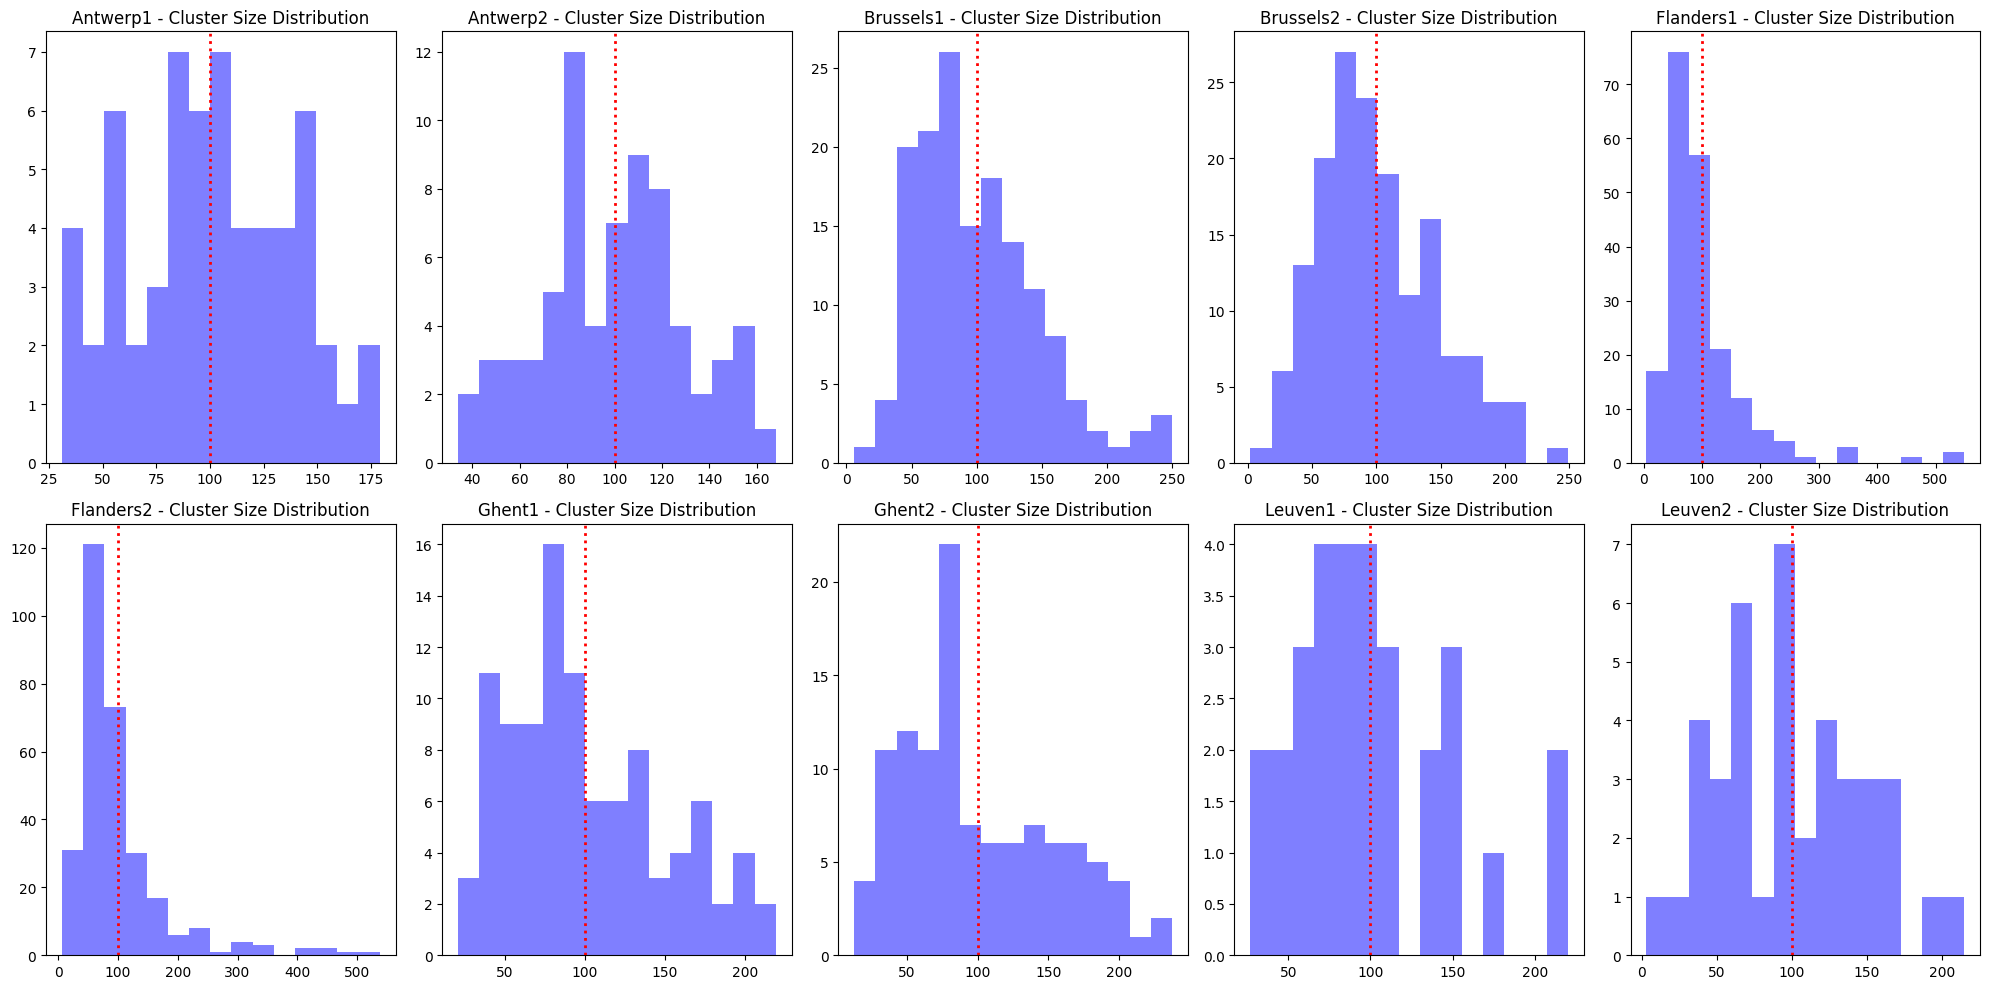

In [ ]:
# import matplotlib.pyplot as plt

# Assuming you have a dictionary 'cluster_dict' containing 'Length of clusters' and 'Mean length of clusters' for each instance

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Loop over instances and axes at the same time
for instance, ax in zip(cluster_dict, axes):
    # Create the histogram for cluster sizes
    cluster_sizes = cluster_dict[instance]['Length of clusters']
    ax.hist(cluster_sizes, color='blue', bins=15, alpha=0.5)

    # Draw a dotted red line at the mean
    mean_length = cluster_dict[instance]['Mean length of clusters']
    ax.axvline(mean_length, color='red', linestyle='dotted', linewidth=2)

    # Optionally, add a title to each subplot
    ax.set_title(f'{instance} - Cluster Size Distribution')

# Show the full plot with all subplots
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Diss_Code/Figures/cluster_size_distributions_full_plots.png')
plt.show()


In [ ]:
len(Antwerp1.instance_cluster())

60

In [ ]:
instance_cluster = VRP.instance_cluster()

In [ ]:
instance_cluster_torch, POMO_test_set, Kool_test_set_depot, Kool_test_set_centroid, POMO_size = VRP.instance_cluster_as_torch()

In [ ]:
# POMO_test_set['cluster_0']

In [ ]:
kool_test_depot_normalized = min_max_normalizer(Kool_test_set_depot)

In [ ]:
kool_test_centroid_normalized = min_max_normalizer(Kool_test_set_centroid)

## Plotting Individual Clusters

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_first_5_individual_clusters(self, save_file):
    instance_cluster_dict = self
    # unique_clusters = np.unique(self.cluster_labels)
    # num_clusters = len(unique_clusters)

    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))

    for i in range(5):
        cluster_data = instance_cluster_dict[f'cluster_{i}']['node_xy']
        x_customer_cluster = cluster_data[:, 0]
        y_customer_cluster = cluster_data[:, 1]

        ax = axs[i]  # Accessing the i-th subplot

        ax.scatter(x_customer_cluster, y_customer_cluster, c='lightsteelblue')
        ax.scatter(instance_cluster_dict[f'cluster_{i}']['centroid'][0], instance_cluster_dict[f'cluster_{i}']['centroid'][1], c='red', marker='x')
        ax.scatter(self.x_depot/np.max(self.customer_coords), self.y_depot/np.max(self.customer_coords), marker='*', c='lime', s=200, edgecolor='black')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title('Cluster ' + str(i))

    plt.tight_layout()
    plt.savefig(save_file)
    plt.show()
    plt.close()



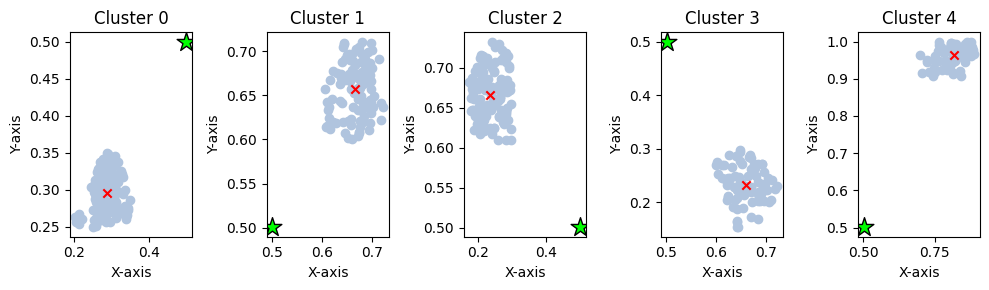

In [ ]:
plot_first_5_individual_clusters(Antwerp1.instance_cluster_dict, '/content/drive/MyDrive/Diss_Code/Figures/first_5_clusters')

In [ ]:
def plot_first_5_x_dist(self, save_file):
        instance_cluster_dict = self
        # unique_clusters = np.unique(self.cluster_labels)
        # num_clusters = len(unique_clusters)

        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))

        for i in range(5):
            ax = axs[i]
            # ax.hist([instance_cluster_dict[f'cluster_{i}']['node_xy'][:, 0], instance_cluster_dict[f'cluster_{i}']['depot_xy'][0]])
            ax.hist([instance_cluster_dict[f'cluster_{i}']['node_xy'][:, 0]])
            ax.set_xlabel('X Values')
            ax.set_ylabel('Amount')
            ax.set_title('Cluster ' + str(i))

        plt.tight_layout()
        plt.savefig(save_file)
        plt.show()

In [ ]:
def plot_first_5_y_dist(self, save_file):
    instance_cluster_dict = self
    # unique_clusters = np.unique(self.cluster_labels)
    # num_clusters = len(unique_clusters)

    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))

    for i in range(5):
        ax = axs[i]
        ax.hist([instance_cluster_dict[f'cluster_{i}']['node_xy'][:, 1], instance_cluster_dict[f'cluster_{i}']['depot_xy'][1]])
        # ax.hist([instance_cluster_dict[f'cluster_{i}']['node_xy'][:, 1]])
        ax.set_xlabel('Y Values')
        ax.set_ylabel('Amount')
        ax.set_title('Cluster ' + str(i))

    plt.tight_layout()
    plt.savefig(save_file)
    plt.show()

In [ ]:
# Antwerp1.instance_cluster_dict['cluster_0']

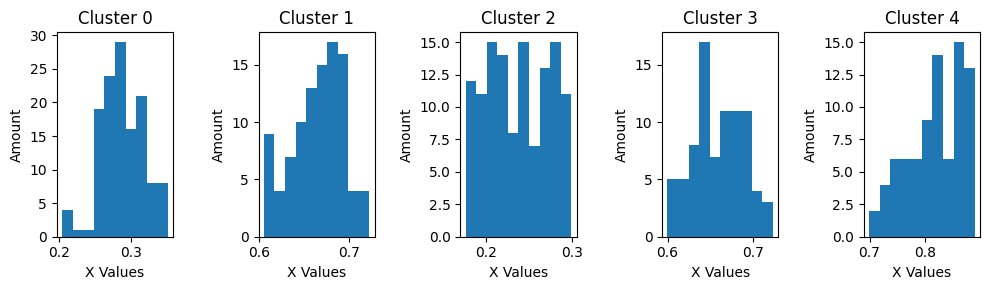

In [ ]:
plot_first_5_x_dist(Antwerp1.instance_cluster_dict, '/content/drive/MyDrive/Diss_Code/Figures/first_5_clusters_x_dist_no_depot')

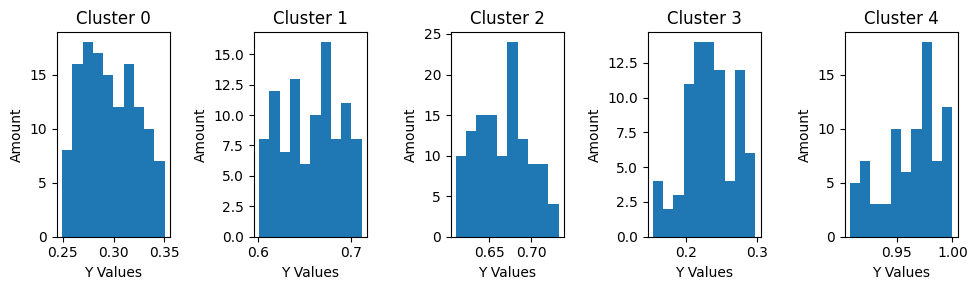

In [ ]:
plot_first_5_y_dist(Antwerp1.instance_cluster_dict, '/content/drive/MyDrive/Diss_Code/Figures/first_5_clusters_y_dist_no_depot')

In [ ]:
def plot_individual_clusters(self):
      instance_cluster_dict = self.instance_cluster_dict
      unique_clusters = np.unique(self.cluster_labels)
      num_clusters = len(unique_clusters)

      fig, axs = plt.subplots(int(num_clusters / (len(self.customer_coords) / 1000)), int(num_clusters / 10), figsize=(15, 20))

      # for i, cluster in enumerate(instance_cluster_dict):

      for i, cluster in enumerate(instance_cluster_dict):
            cluster_data = [instance_cluster_dict[cluster]['node_xy']]
            x_customer_cluster = cluster_data[:, 0]
            y_customer_cluster = cluster_data[:, 1]
            # print(x_customer_cluster)
            ax = axs[i // int(num_clusters / 10), i % int(num_clusters / 10)] if num_clusters > 1 else axs
            ax.scatter(x_customer_cluster, y_customer_cluster, c='lightsteelblue')
            ax.scatter(instance_cluster_dict[f'cluster_{i}']['centroid'][0], instance_cluster_dict[f'cluster_{i}']['centroid'][1], c='red', marker='x')
            ax.scatter(self.x_depot/np.max(self.customer_coords), self.y_depot/np.max(self.customer_coords), marker = '*', c='lime', s=200, edgecolor='black')
            ax.set_xlabel('X-axis')
            ax.set_ylabel('Y-axis')
            ax.set_title('Cluster ' + str(cluster))

      plt.tight_layout()
      plt.show()
      plt.close()

## Min Max

In [ ]:
# Antwerp

Antwerp1_normalized_depot = min_max_depot_normalizer(Antwerp1.instance_cluster_dict)
Antwerp1_normalized_centroid = min_max_centorid_normalizer(Antwerp1.instance_cluster_dict)

Antwerp2_normalized_depot = min_max_depot_normalizer(Antwerp2.instance_cluster_dict)
Antwerp2_normalized_centroid = min_max_centorid_normalizer(Antwerp2.instance_cluster_dict)

# Brussels

Brussels1_normalized_depot = min_max_depot_normalizer(Brussels1.instance_cluster_dict)
Brussels1_normalized_centroid = min_max_centorid_normalizer(Brussels1.instance_cluster_dict)

Brussels2_normalized_depot = min_max_depot_normalizer(Brussels2.instance_cluster_dict)
Brussels2_normalized_centroid = min_max_centorid_normalizer(Brussels2.instance_cluster_dict)

# Flanders

Flanders1_normalized_depot = min_max_depot_normalizer(Flanders1.instance_cluster_dict)
Flanders1_normalized_centroid = min_max_centorid_normalizer(Flanders1.instance_cluster_dict)

Flanders2_normalized_depot = min_max_depot_normalizer(Flanders2.instance_cluster_dict)
Flanders2_normalized_centroid = min_max_centorid_normalizer(Flanders2.instance_cluster_dict)

# Ghent

Ghent1_normalized_depot = min_max_depot_normalizer(Ghent1.instance_cluster_dict)
Ghent1_normalized_centroid = min_max_centorid_normalizer(Ghent1.instance_cluster_dict)

Ghent2_normalized_depot = min_max_depot_normalizer(Ghent2.instance_cluster_dict)
Ghent2_normalized_centroid = min_max_centorid_normalizer(Ghent2.instance_cluster_dict)

# Leuven

Leuven1_normalized_depot = min_max_depot_normalizer(Leuven1.instance_cluster_dict)
Leuven1_normalized_centroid = min_max_centorid_normalizer(Leuven1.instance_cluster_dict)

Leuven2_normalized_depot = min_max_depot_normalizer(Leuven2.instance_cluster_dict)
Leuven2_normalized_centroid = min_max_centorid_normalizer(Leuven2.instance_cluster_dict)

In [ ]:
def plot_first_5_individual_clusters(self, save_file):
    instance_cluster_dict = self
    # unique_clusters = np.unique(self.cluster_labels)
    # num_clusters = len(unique_clusters)

    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))

    for i in range(5):
        cluster_data = instance_cluster_dict[f'cluster_{i}']['node_xy']
        x_customer_cluster = cluster_data[:, 0]
        y_customer_cluster = cluster_data[:, 1]

        ax = axs[i]  # Accessing the i-th subplot

        ax.scatter(x_customer_cluster, y_customer_cluster, c='lightsteelblue')
        # ax.scatter(instance_cluster_dict[f'cluster_{i}']['centroid'][0], instance_cluster_dict[f'cluster_{i}']['centroid'][1], c='red', marker='x')
        ax.scatter(self[f'cluster_{i}']['depot_xy'][0], self[f'cluster_{i}']['depot_xy'][1], marker='*', c='lime', s=200, edgecolor='black')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title('Cluster ' + str(i))

    plt.tight_layout()
    plt.savefig(save_file)
    plt.show()
    plt.close()

In [ ]:
# plot_first_5_individual_clusters(Antwerp1_normalized_depot, '/content/drive/MyDrive/Diss_Code/Figures/first_5_clusters_normalized')
# plot_first_5_x_dist(Antwerp1_normalized_depot, '/content/drive/MyDrive/Diss_Code/Figures/first_5_clusters_x_dist_depot_normalized')
# plot_first_5_y_dist(Antwerp1_normalized_depot, '/content/drive/MyDrive/Diss_Code/Figures/first_5_clusters_y_dist_depot_normalized')

In [ ]:
# plot_first_5_individual_clusters(Antwerp1_normalized_centroid, '/content/drive/MyDrive/Diss_Code/Figures/first_5_clusters_normalized_centroid')
# plot_first_5_x_dist(Antwerp1_normalized_centroid, '/content/drive/MyDrive/Diss_Code/Figures/first_5_clusters_x_dist_depot_normalized_centroid')
# plot_first_5_y_dist(Antwerp1_normalized_centroid, '/content/drive/MyDrive/Diss_Code/Figures/first_5_clusters_y_dist_depot_normalized_centroid')

## Creating Files for Kool Testing

In [ ]:
# Files where the depot is the depot
for cluster in Kool_test_set_depot:
  # Save the object as a pickle file
  with open(f'/content/drive/MyDrive/Diss_Code/Full_test_sets_benchmarks/kool_{cluster}.pkl', 'wb') as file:
      pickle.dump(Kool_test_set_depot[cluster], file)

In [ ]:
# Files where the centroid is the depot

for cluster in Kool_test_set_centroid:
  # Save the object as a pickle file
  with open(f'/content/drive/MyDrive/Diss_Code/My_Code/Kool_centroid/kool_{cluster}.pkl', 'wb') as file:
      pickle.dump(Kool_test_set_centroid[cluster], file)

In [ ]:
# Files where the depot is the depot and is normalised

for cluster in kool_test_depot_normalized:
  # Save the object as a pickle file
  with open(f'/content/drive/MyDrive/Diss_Code/Full_test_sets_benchmarks/kool_normalized_{cluster}.pkl', 'wb') as file:
      pickle.dump(kool_test_depot_normalized[cluster], file)

In [ ]:
# Files where the centroid is the depot and is normalised

for cluster in kool_test_centroid_normalized:
  # Save the object as a pickle file
  with open(f'/content/drive/MyDrive/Diss_Code/My_Code/Kool_centroid_normalized/kool_{cluster}.pkl', 'wb') as file:
      pickle.dump(kool_test_centroid_normalized[cluster], file)

Benchmark - Unclustered

In [ ]:
with open('/content/drive/MyDrive/Diss_Code/My_Code/Unclustered/benchmark.pkl', 'wb') as file:
    pickle.dump(benchmark, file)

# Creating Testing Files

### Function

In [ ]:
def test_set_creater_depot(self, normalised_dict, centroid):

  if normalised_dict is None:
    Kool_test_set_depot = {}
    if centroid is False:


      for cluster in self.instance_cluster_dict:
            Kool_test_set_depot[cluster] = (self.instance_cluster_dict[cluster]['depot_xy'].tolist(),
                                        self.instance_cluster_dict[cluster]['node_xy'].tolist(),
                                        self.instance_cluster_dict[cluster]['node_demand'].tolist(),
                                        self.capacity)
    else:


      for cluster in self.instance_cluster_dict:
            Kool_test_set_depot[cluster] = (self.instance_cluster_dict[cluster]['centroid'].tolist(),
                                        self.instance_cluster_dict[cluster]['node_xy'].tolist(),
                                        self.instance_cluster_dict[cluster]['node_demand'].tolist(),
                                        self.capacity)

  else:

    Kool_test_set_depot = {}

    for cluster in normalised_dict:
          Kool_test_set_depot[cluster] = (normalised_dict[cluster]['depot_xy'].tolist(),
                                      normalised_dict[cluster]['node_xy'].tolist(),
                                      normalised_dict[cluster]['node_demand'].tolist(),
                                      self.capacity)

  return Kool_test_set_depot

### Creating Datasets



*  test_1 - vanilla dataset
*  test_2 - centroid as intermediary depot
*   test_3 - test 1 normalised
*   test_4 - test 2 normalised










#### Setting up the datasets

In [ ]:
# Antwerp
Antwerp1_test_1 = test_set_creater_depot(Antwerp1, None, False)
# Antwerp1_test_2 = test_set_creater_depot(Antwerp1, None, True)
Antwerp1_test_3 = test_set_creater_depot(Antwerp1, Antwerp1_normalized_depot, False)
# Antwerp1_test_4 = test_set_creater_depot(Antwerp1, Antwerp1_normalized_centroid, False)

Antwerp2_test_1 = test_set_creater_depot(Antwerp2, None, False)
# Antwerp2_test_2 = test_set_creater_depot(Antwerp2, None, True)
Antwerp2_test_3 = test_set_creater_depot(Antwerp2, Antwerp2_normalized_depot, False)
# Antwerp2_test_4 = test_set_creater_depot(Antwerp2, Antwerp2_normalized_centroid, False)

# Brussels
Brussels1_test_1 = test_set_creater_depot(Brussels1, None, False)
# Brussels1_test_2 = test_set_creater_depot(Brussels1, None, True)
Brussels1_test_3 = test_set_creater_depot(Brussels1, Brussels1_normalized_depot, False)
# Brussels1_test_4 = test_set_creater_depot(Brussels1, Brussels1_normalized_centroid, False)

Brussels2_test_1 = test_set_creater_depot(Brussels2, None, False)
# Brussels2_test_2 = test_set_creater_depot(Brussels2, None, True)
Brussels2_test_3 = test_set_creater_depot(Brussels2, Brussels2_normalized_depot, False)
# Brussels2_test_4 = test_set_creater_depot(Brussels2, Brussels2_normalized_centroid, False)

# Flanders
Flanders1_test_1 = test_set_creater_depot(Flanders1, None, False)
# Flanders1_test_2 = test_set_creater_depot(Flanders1, None, True)
Flanders1_test_3 = test_set_creater_depot(Flanders1, Flanders1_normalized_depot, False)
# Flanders1_test_4 = test_set_creater_depot(Flanders1, Flanders1_normalized_centroid, False)

Flanders2_test_1 = test_set_creater_depot(Flanders2, None, False)
# Flanders2_test_2 = test_set_creater_depot(Flanders2, None, True)
Flanders2_test_3 = test_set_creater_depot(Flanders2, Flanders2_normalized_depot, False)
# Flanders2_test_4 = test_set_creater_depot(Flanders2, Flanders2_normalized_centroid, False)

# Ghent
Ghent1_test_1 = test_set_creater_depot(Ghent1, None, False)
# Ghent1_test_2 = test_set_creater_depot(Ghent1, None, True)
Ghent1_test_3 = test_set_creater_depot(Ghent1, Ghent1_normalized_depot, False)
# Ghent1_test_4 = test_set_creater_depot(Ghent1, Ghent1_normalized_centroid, False)

Ghent2_test_1 = test_set_creater_depot(Ghent2, None, False)
# Ghent2_test_2 = test_set_creater_depot(Ghent2, None, True)
Ghent2_test_3 = test_set_creater_depot(Ghent2, Ghent2_normalized_depot, False)
# Ghent2_test_4 = test_set_creater_depot(Ghent2, Ghent2_normalized_centroid, False)

# Leuven
Leuven1_test_1 = test_set_creater_depot(Leuven1, None, False)
# Leuven1_test_2 = test_set_creater_depot(Leuven1, None, True)
Leuven1_test_3 = test_set_creater_depot(Leuven1, Leuven1_normalized_depot, False)
# Leuven1_test_4 = test_set_creater_depot(Leuven1, Leuven1_normalized_centroid, False)

Leuven2_test_1 = test_set_creater_depot(Leuven2, None, False)
# Leuven2_test_2 = test_set_creater_depot(Leuven2, None, True)
Leuven2_test_3 = test_set_creater_depot(Leuven2, Leuven2_normalized_depot, False)
# Leuven2_test_4 = test_set_creater_depot(Leuven2, Leuven2_normalized_centroid, False)

In [ ]:
# Ghent1_test_4 = test_set_creater_depot(Ghent1, Ghent1_normalized_centroid, False)

#### Writing Datasets to Drive

In [ ]:
# Import the pickle module
import pickle

# List of test datasets and their corresponding names
test_datasets = [
    ('Antwerp1', 'test_1', Antwerp1_test_1),
    ('Antwerp1', 'test_2', Antwerp1_test_2),
    ('Antwerp1', 'test_3', Antwerp1_test_3),
    ('Antwerp1', 'test_4', Antwerp1_test_4)

    ('Antwerp2', 'test_1', Antwerp2_test_1),
    ('Antwerp2', 'test_2', Antwerp2_test_2),
    ('Antwerp2', 'test_3', Antwerp2_test_3),
    ('Antwerp2', 'test_4', Antwerp2_test_4)

    ('Brussels1', 'test_1', Brussels1_test_1),
    ('Brussels1', 'test_2', Brussels1_test_2),
    ('Brussels1', 'test_3', Brussels1_test_3),
    ('Brussels1', 'test_4', Brussels1_test_4)

    ('Brussels2', 'test_1', Brussels2_test_1),
    ('Brussels2', 'test_2', Brussels2_test_2),
    ('Brussels2', 'test_3', Brussels2_test_3),
    ('Brussels2', 'test_4', Brussels2_test_4)

    ('Flanders1', 'test_1', Flanders1_test_1),
    ('Flanders1', 'test_2', Flanders1_test_2),
    ('Flanders1', 'test_3', Flanders1_test_3),
    ('Flanders1', 'test_4', Flanders1_test_4)

    ('Flanders2', 'test_1', Flanders2_test_1),
    ('Flanders2', 'test_2', Flanders2_test_2),
    ('Flanders2', 'test_3', Flanders2_test_3),
    ('Flanders2', 'test_4', Flanders2_test_4)

    ('Ghent1', 'test_1', Ghent1_test_1),
    ('Ghent1', 'test_2', Ghent1_test_2),
    ('Ghent1', 'test_3', Ghent1_test_3),
    ('Ghent1', 'test_4', Ghent1_test_4)

    ('Ghent2', 'test_1', Ghent2_test_1),
    ('Ghent2', 'test_2', Ghent2_test_2),
    ('Ghent2', 'test_3', Ghent2_test_3),
    ('Ghent2', 'test_4', Ghent2_test_4)

    ('Leuven1', 'test_1', Leuven1_test_1),
    ('Leuven1', 'test_2', Leuven1_test_2),
    ('Leuven1', 'test_3', Leuven1_test_3),
    ('Leuven1', 'test_4', Leuven1_test_4)

    ('Leuven2', 'test_1', Leuven2_test_1),
    ('Leuven2', 'test_2', Leuven2_test_2),
    ('Leuven2', 'test_3', Leuven2_test_3)
    ('Leuven2', 'test_4', Leuven2_test_4)


]

# Define the base path where you want to save the files
base_path = '/content/drive/MyDrive/Diss_Code/benchmark_full'

# Iterate through each test dataset
for instance, test_name, test_data in test_datasets:
    for cluster in test_data:
        # Get the corresponding test set
        test_set = test_data[cluster]

        # Create the folder path for the current test dataset and cluster
        folder_path = f"{base_path}/{instance}_{test_name}_{cluster}_full_benchmark.pkl"

        # Save the test_set object as a pickle file
        with open(folder_path, 'wb') as file:
            pickle.dump(test_set, file)


# Preliminary Data Analysis

## Full datasets

In [ ]:
%cd /content/drive/MyDrive/Diss_Code/Final_Results/full_benchmarks_for_post_testing

/content/drive/MyDrive/Diss_Code/Final_Results/full_benchmarks_for_post_testing


In [ ]:
Antwerp1_max = 1999
Antwerp2_max = 1999

Brussels1_max = 1997
Brussels2_max = 1999

Flanders1_max = 26694
Flanders2_max = 26848

Ghent1_max = 1999
Ghent2_max = 1997

Leuven1_max = 1903
Leuven2_max = 1990

In [ ]:
df = pd.read_csv('Antwerp1_full.csv')

In [ ]:
vals = ast.literal_eval(df['cluster_0'][0])

In [ ]:
x_values = []
y_values = []

for item in vals:
    if isinstance(item[0], list):  # Nested list of x and y pairs
        for sub_item in item:
            x_values.append(sub_item[0]*Antwerp1_max)
            y_values.append(sub_item[1]*Antwerp1_max)
    else:  # Single x and y pair
        x_values.append(item[0]*Antwerp1_max)
        y_values.append(item[1]*Antwerp1_max)

In [ ]:
x_values

[0.5002501250625313, [0.30115057528764383, 0.4352176088044022]]

In [ ]:
def data_summary(csv_file, max_value):

  df = pd.read_csv(csv_file)

  vals = ast.literal_eval(df['cluster_0'][0])

  x_values = []
  y_values = []

  for item in vals:
      if isinstance(item[0], list):  # Nested list of x and y pairs
          for sub_item in item:
              x_values.append(sub_item[0]*max_value)
              y_values.append(sub_item[1]*max_value)
      else:  # Single x and y pair
          x_values.append(item[0]*max_value)
          y_values.append(item[1]*max_value)

  # Calculate the five-number summary for x values
  x_stats = {
    'minimum': round(np.min(x_values), 0),
    'first_quartile': np.percentile(x_values, 25),
    'median': np.percentile(x_values, 50),
    'third_quartile': np.percentile(x_values, 75),
    'maximum': np.max(x_values),
    'skewness': skew(x_values),
    'kurtosis': kurtosis(x_values)
    }

  y_stats = {
      'minimum': round(np.min(y_values), 0),
      'first_quartile': np.percentile(y_values, 25),
      'median': np.percentile(y_values, 50),
      'third_quartile': np.percentile(y_values, 75),
      'maximum': np.max(y_values),
      'skewness': skew(y_values),
      'kurtosis': kurtosis(y_values)
      }

  return x_stats, y_stats


In [ ]:
def descriptive_stats_csv_writter(filename, x_stats, y_stats):

  with open(filename, 'w', newline='') as csvfile:
      fieldnames = ['Statistic', 'X Values', 'Y Values']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

      writer.writeheader()
      for stat in x_stats:
          writer.writerow({'Statistic': stat, 'X Values': x_stats[stat], 'Y Values': y_stats[stat]})

  print("CSV file saved:", filename)

In [ ]:
x, y = data_summary('Antwerp1_full.csv', Antwerp1_max)
descriptive_stats_csv_writter('Antwerp1_DS.csv', x, y)

x, y = data_summary('Antwerp2_full.csv', Antwerp2_max)
descriptive_stats_csv_writter('Antwerp2_DS.csv', x, y)

x, y = data_summary('Leuven1_full.csv', Leuven1_max)
descriptive_stats_csv_writter('Leuven1_DS.csv', x, y)

x, y = data_summary('Leuven2_full.csv', Leuven2_max)
descriptive_stats_csv_writter('Leuven2_DS.csv', x, y)

x, y = data_summary('Ghent1_full.csv', Ghent1_max)
descriptive_stats_csv_writter('Ghent1_DS.csv', x, y)

x, y = data_summary('Ghent2_full.csv', Ghent2_max)
descriptive_stats_csv_writter('Ghent2_DS.csv', x, y)

x, y = data_summary('Brussels1_full.csv', Brussels1_max)
descriptive_stats_csv_writter('Brussels1_DS.csv', x, y)

x, y = data_summary('Brussels2_full.csv', Brussels2_max)
descriptive_stats_csv_writter('Brussels2_DS.csv', x, y)

x, y = data_summary('Flanders1_full.csv', Flanders1_max)
descriptive_stats_csv_writter('Flanders1_DS.csv', x, y)

x, y = data_summary('Flanders2_full.csv', Flanders2_max)
descriptive_stats_csv_writter('Flanders2_DS.csv', x, y)

CSV file saved: Antwerp1_DS.csv
CSV file saved: Antwerp2_DS.csv
CSV file saved: Leuven1_DS.csv
CSV file saved: Leuven2_DS.csv
CSV file saved: Ghent1_DS.csv
CSV file saved: Ghent2_DS.csv
CSV file saved: Brussels1_DS.csv
CSV file saved: Brussels2_DS.csv
CSV file saved: Flanders1_DS.csv
CSV file saved: Flanders2_DS.csv


## Clusters

In [ ]:
%cd /content/drive/MyDrive/Diss_Code/My_Code/Instances

/content/drive/MyDrive/Diss_Code/My_Code/Instances


### Reading in data

#### A1

In [ ]:
# Doing Antwerp 1 test 1
A1_t1 = []

for i in range(4):
    file_path = f'Antwerp1/test_1/kool_cluster_{i}.pkl'

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        A1_t1.append(data[0:2])

In [ ]:
# Doing Antwerp 1 test 2
A1_t2 = []

for i in range(4):
    file_path = f'Antwerp1/test_2/kool_cluster_{i}.pkl'

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        data_centroid = pickle.load(file)
        A1_t2.append(data_centroid[0:2])


In [ ]:
# Doing Antwerp 1 test 3
A1_t3 = []

for i in range(4):
    file_path = f'Antwerp1/test_3/kool_cluster_{i}.pkl'

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        data_centroid = pickle.load(file)
        A1_t3.append(data_centroid[0:2])

In [ ]:
# Doing Antwerp 1 test 4
A1_t4 = []

for i in range(4):
    file_path = f'Antwerp1/test_4/kool_cluster_{i}.pkl'

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        data_centroid = pickle.load(file)
        A1_t4.append(data_centroid[0:2])

First going to do the centroid version cause its easier

#### A2

In [ ]:
# Doing Antwerp 1 test 1
A2_t1 = []

for i in range(4):
    file_path = f'Antwerp2/test_1/kool_cluster_{i}.pkl'

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        A2_t1.append(data[0:2])

# Doing Antwerp 1 test 1
A2_t2 = []

for i in range(4):
    file_path = f'Antwerp2/test_2/kool_cluster_{i}.pkl'

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        A2_t2.append(data[0:2])

# Doing Antwerp 1 test 1
A2_t3 = []

for i in range(4):
    file_path = f'Antwerp2/test_3/kool_cluster_{i}.pkl'

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        A2_t3.append(data[0:2])

# Doing Antwerp 1 test 1
A2_t4 = []

for i in range(4):
    file_path = f'Antwerp2/test_4/kool_cluster_{i}.pkl'

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        A2_t4.append(data[0:2])

## Function

In [ ]:
def data_summary_depot(data):
  # creating new list that contains the depot and the rest of the cluster
  new_list = []

  new_list.append(data[0])

  for item in data[1]:
    new_list.append(item)

  x_values = []
  y_values = []

  for item in new_list:
      if isinstance(item[0], list):  # Nested list of x and y pairs
          for sub_item in item:
              x_values.append(sub_item[0])
              y_values.append(sub_item[1])
      else:  # Single x and y pair
          x_values.append(item[0])
          y_values.append(item[1])

  # Calculate the five-number summary for x values
  x_stats = {
    'minimum': np.min(x_values),
    'first_quartile': np.percentile(x_values, 25),
    'median': np.percentile(x_values, 50),
    'third_quartile': np.percentile(x_values, 75),
    'maximum': np.max(x_values),
    'skewness': skew(x_values),
    'kurtosis': kurtosis(x_values)
    }

  y_stats = {
      'minimum':np.min(y_values),
      'first_quartile': np.percentile(y_values, 25),
      'median': np.percentile(y_values, 50),
      'third_quartile': np.percentile(y_values, 75),
      'maximum':np.max(y_values),
      'skewness': skew(y_values),
      'kurtosis': kurtosis(y_values)
      }

  return x_stats, y_stats

In [ ]:
def descriptive_stats_csv_writter(filename, x_stats, y_stats):

  with open(filename, 'w', newline='') as csvfile:
      fieldnames = ['Statistic', 'X Values', 'Y Values']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

      writer.writeheader()
      for stat in x_stats:
          writer.writerow({'Statistic': stat, 'X Values': x_stats[stat], 'Y Values': y_stats[stat]})

  print("CSV file saved:", filename)

Now need to do the depot version where we append the depot to the cluster list

## Depot

### A1

In [ ]:
x, y = data_summary_depot(A1_t1[0])
descriptive_stats_csv_writter('A1_t1.csv', x, y)

x, y = data_summary_depot(A1_t2[0])
descriptive_stats_csv_writter('A1_t2.csv', x, y)

x, y = data_summary_depot(A1_t3[0])
descriptive_stats_csv_writter('A1_t3.csv', x, y)

x, y = data_summary_depot(A1_t4[0])
descriptive_stats_csv_writter('A1_t4.csv', x, y)

CSV file saved: A1_t1.csv
CSV file saved: A1_t2.csv
CSV file saved: A1_t3.csv
CSV file saved: A1_t4.csv


### A2

In [ ]:
x, y = data_summary_depot(A2_t1[0])
descriptive_stats_csv_writter('A2_t1.csv', x, y)

x, y = data_summary_depot(A2_t2[0])
descriptive_stats_csv_writter('A2_t2.csv', x, y)

x, y = data_summary_depot(A2_t3[0])
descriptive_stats_csv_writter('A2_t3.csv', x, y)

x, y = data_summary_depot(A2_t4[0])
descriptive_stats_csv_writter('A2_t4.csv', x, y)

CSV file saved: A2_t1.csv
CSV file saved: A2_t2.csv
CSV file saved: A2_t3.csv
CSV file saved: A2_t4.csv


## Cluster Sizes

In [ ]:
%cd /content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing

/content/drive/MyDrive/Diss_Code/Final_Results/initial_datasets_post_testing


### Function

In [ ]:
def data_summary_cluster_sizes(csv_file):
  df = pd.read_csv(csv_file)

  for col in df.columns:
    df[col] = df[col].apply(ast.literal_eval)

  cluster_length_list = []

  for item in df:
    cluster_length_list.append(len(df[item][0][1]))

  y_stats = {
      'minimum': round(np.min(cluster_length_list), 0),
      'first_quartile': np.percentile(cluster_length_list, 25),
      'median': np.percentile(cluster_length_list, 50),
      'third_quartile': np.percentile(cluster_length_list, 75),
      'maximum': np.max(cluster_length_list),
      'skewness': skew(cluster_length_list),
      'kurtosis': kurtosis(cluster_length_list)
      }

  return y_stats

In [ ]:
def descriptive_stats_csv_writter(filename, y_stats):

  with open(filename, 'w', newline='') as csvfile:
      fieldnames = ['Statistic', 'Y Values']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

      writer.writeheader()
      for stat in y_stats:
          writer.writerow({'Statistic': stat, 'Y Values': y_stats[stat]})

  print("CSV file saved:", filename)

### Running

In [ ]:
y = data_summary_cluster_sizes('Antwerp1_depot.csv')
descriptive_stats_csv_writter('Antwerp1.csv', y)

y = data_summary_cluster_sizes('Antwerp2_depot.csv')
descriptive_stats_csv_writter('Antwerp2.csv', y)

y = data_summary_cluster_sizes('Brussels1_depot.csv')
descriptive_stats_csv_writter('Brussels1.csv', y)

y = data_summary_cluster_sizes('Brussels2_depot.csv')
descriptive_stats_csv_writter('Brussels2.csv', y)

y = data_summary_cluster_sizes('Flanders1_depot.csv')
descriptive_stats_csv_writter('Flanders1.csv', y)

y = data_summary_cluster_sizes('Flanders2_depot.csv')
descriptive_stats_csv_writter('Flanders2.csv', y)

y = data_summary_cluster_sizes('Ghent1_depot.csv')
descriptive_stats_csv_writter('Ghent1.csv', y)

y = data_summary_cluster_sizes('Ghent2_depot.csv')
descriptive_stats_csv_writter('Ghent2.csv', y)

y = data_summary_cluster_sizes('Leuven1_depot.csv')
descriptive_stats_csv_writter('Leuven1.csv', y)

y = data_summary_cluster_sizes('Leuven2_depot.csv')
descriptive_stats_csv_writter('Leuven2.csv', y)

CSV file saved: Antwerp1.csv
CSV file saved: Antwerp2.csv
CSV file saved: Brussels1.csv
CSV file saved: Brussels2.csv
CSV file saved: Flanders1.csv
CSV file saved: Flanders2.csv
CSV file saved: Ghent1.csv
CSV file saved: Ghent2.csv
CSV file saved: Leuven1.csv
CSV file saved: Leuven2.csv
